In [5]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import process_model as pm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
inverted_pendulum = pm.InvertedPendulum(
    1.0,
    2.0,
    30.0,
    0.4,
    5.0,
)

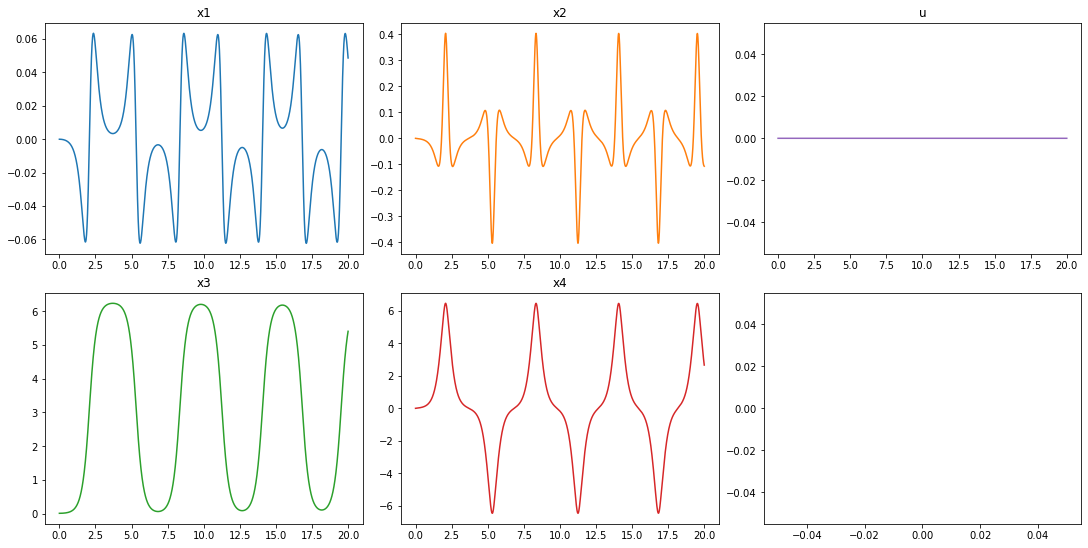

In [7]:
timespan = 20
Ts = 0.01
initial_state = np.array([0.0, 0.0, 0.01, 0.0])

simulator = pm.PlantSimulator(
    plant=inverted_pendulum,
    timestep=Ts,
    simulation_time=timespan,
)

simulator.set_controller(lambda x: np.array([0]))

state_evolution, actuator_evolution, t = simulator.simulate_system(initial_state)

simulator.plot_state_evolution(state_evolution, t)

In [8]:
process_dynamics = inverted_pendulum.dynamics_continuous_sym()
dynamics_jacobian_x = process_dynamics.jacobian(sp.symbols("x1:5"))
A_c = dynamics_jacobian_x.evalf(subs={'x1': 0.0, 'x2': 0.0, 'x3':0.0, 'x4':0.0})
A_c = np.array(A_c).astype(np.float64)

dynamics_jacobian_u = process_dynamics.jacobian([sp.symbols("u1")])
B_c = dynamics_jacobian_u.evalf(subs={'x1': 0.0, 'x2': 0.0, 'x3':0.0, 'x4':0.0})
B_c = np.array(B_c).astype(np.float64)

In [9]:
# Euler forward discretization of system
A_d = np.eye(A_c.shape[0]) + Ts * A_c
B_d = Ts * B_c

# LQR Controller Design
## Wikipedia:
the optimal control sequence minimizing the performance index is given by:
$$
u_{k}=-Fx_{k}\,
$$
where:
$$
F=(R+B^{T}PB)^{{-1}}(B^{T}PA+N^{T})\,
$$
and $P$ is the unique positive definite solution to the discrete time algebraic Riccati equation (DARE). $P$ can be found by iterating the dynamic Riccati equation until it converges:
$$
P_{{k-1}}=A^{T}P_{k}A-(A^{T}P_{k}B+N)\left(R+B^{T}P_{k}B\right)^{{-1}}(B^{T}P_{k}A+N^{T})+Q
$$ 
from terminal condition $P_{N}=Q$.

In [10]:
R = 1
Q = np.eye(A_d.shape[0])
Q[0,0] = Q[2,2] = 1000

P = Q

iterations = 0
while True:
    P_new = A_d.transpose() @ P @ A_d - (A_d.transpose() @ P @ B_d) @ np.linalg.inv(R + B_d.transpose() @ P @ B_d) @ (B_d.transpose() @ P @ A_d) + Q
    iterations += 1
    if np.linalg.norm(P-P_new) < 1e-6:
        P = P_new
        print(iterations)
        print(P)
        break
    else:
        P = P_new
    

1714
[[  206735.65964433   212606.48660287   974297.39069096   311232.09834642]
 [  212606.48660287   336810.60033201  1693245.06589195   540918.65328957]
 [  974297.39069095  1693245.06589194 14848105.49541604  4671986.50162179]
 [  311232.09834642   540918.65328957  4671986.5016218   1472038.00100732]]


[[ -30.41806227  -63.2849817  -948.34028802 -296.36238705]]


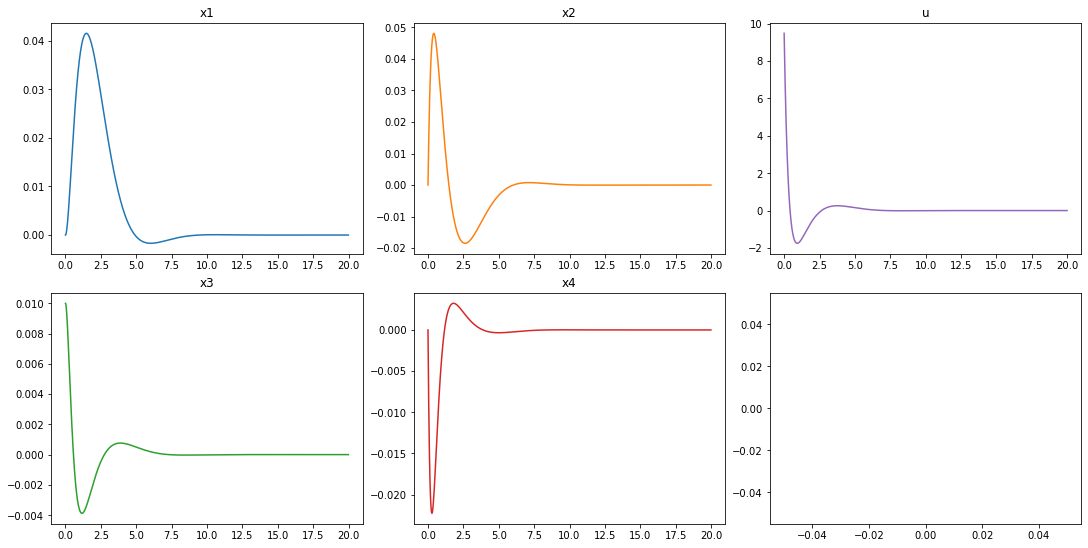

In [45]:
F_inf = np.linalg.inv(R + B_d.transpose() @ P @ B_d) @ (B_d.transpose() @ P @ A_d)

print(F_inf)

#return the element in the array and not the array itself to avoid a warning
lqr_controller = lambda x: (-F_inf @ x)


simulator.set_controller(lqr_controller)

_, _, _ = simulator.simulate_system(initial_state, enable_plot=True)

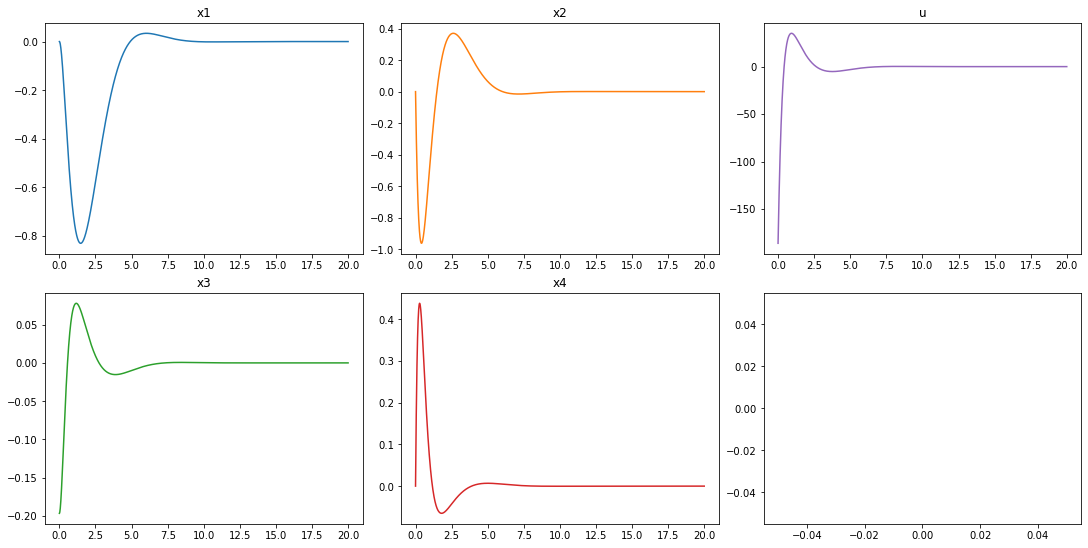

In [44]:
_, _, _ = simulator.simulate_system([0.0, 0.0, -np.pi/16, 0.0], enable_plot=True)